# Roman Road Network #

## Project Overview ##

This project is dedicated to creating an interactive map that visualizes the infrastructure of the ancient Roman Empire, with a particular focus on the Roman road network, ancient ports, and key cities. The primary goal is to provide users with a powerful tool to explore and analyze historical data, allowing them to study the spatial distribution of roads, ports, and cities and obtain detailed information through interactive popups.

## Data Sources ##
1. [**Roman Roads Data**](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/TI0KAU)

The dataset represents a digital version of the Roman roads, derived from the Barrington Atlas. It includes attributes such as the road type (major and minor roads), the length of the road, the data source, and a reliability measure, along with geographic information stored in shapefile format.

2. [**Ancient Ports Data**](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/3KQFUT)

The ancient ports data is based on the work of Arthur de Graauw, who compiled and geolocated ancient harbours and ports by reviewing historical documentation. The dataset comprises approximately 2,900 ancient ports and includes information like port names and their geographic coordinates. In this project, only ports located within the territory of the Roman Empire are displayed.

3. **Roman Cities Data**

The project uses a curated list of 40 key cities from the Roman Empire. For each city, the dataset provides:
- The ancient name of the city
- The province in which the city was located
- The founding date (or an approximate date)
- An estimated population figure
- The modern name (if available)

This information is used to generate detailed popups when users hover over a city marker.

## Project Components ##
1. **Data Preprocessing and Geometry Simplification**

To optimize the map’s performance, the Roman roads geometries are simplified. This is achieved by:
- Reprojecting the data into a metric coordinate system (`EPSG:3857`) so that a simplification tolerance (set, for example, to 1000 meters) can be applied.
- Simplifying the geometries using this tolerance.
- Converting the geometries back to the standard WGS84 coordinate system (`EPSG:4326`) for mapping.

2. **Interactive Map Visualization with Plotly**
The project integrates multiple layers into a single interactive map using `Plotly`. Each layer includes:
- ***Roman Roads:*** Displayed as aggregated line traces with different styling (e.g., `dodgerblue` for major roads and `silver` for minor roads). Detailed hover popups show the road type, rounded length, and data source.
- ***Ancient Ports:*** Represented by small yellow dots. When a user hovers over a port, the port name is displayed.
- ***Roman Cities:*** Displayed as red markers. Hovering over a city marker reveals its ancient name, province, founding date, population, and modern name with a red background for the popup.

3. **Interactive Dashboard with Dash**

The dashboard is built using the Dash framework, allowing users to interact with the data through:
- A dropdown menu to filter roads by class (e.g., major or minor roads).
- A map component that dynamically updates based on the selected road classes.
- Integrated static layers for cities and ports that remain visible regardless of the road filter.
- The interface is designed to update in real time as the user interacts with the dropdown, providing a seamless and engaging experience.

## Technical Implementation ##
- **Programming Language:** Python
- **Libraries and Tools:**
    - ***GeoPandas:*** For working with geospatial data, loading and transforming shapefiles.
    - ***Plotly:*** For creating interactive maps and visualizations.
    - ***Dash:*** For building the interactive web dashboard that allows user filtering and dynamic updates.
    - ***Pandas:*** For managing and processing tabular data for cities and ports.
    - ***Zipfile & OS:*** For extracting the data from zip archives and managing file paths.
- **Core Functionalities:**
    - Data extraction, loading, and preprocessing.
    - Geometry simplification to improve rendering performance.
    - Integration of multiple data layers (roads, ports, and cities) into a single map.
    - Dynamic filtering of roads via an interactive dashboard.
    - Detailed popup information for roads, cities, and ports, enabling users to get historical context at a glance.

In [1]:
import dash
from dash import dcc, html, Input, Output
import geopandas as gpd
import pandas as pd
import plotly.graph_objects as go
import zipfile
import os

### 1. Data Extraction and Loading ###

In [2]:
# Extract the zip file if not already extracted
if not os.path.exists('dataverse_extracted'):
    with zipfile.ZipFile('dataverse_files.zip', 'r') as zip_ref:
        zip_ref.extractall('dataverse_extracted')

In [3]:
# Load the shapefile containing Roman roads
roads_gdf = gpd.read_file(
    os.path.join(
        'dataverse_extracted',
        'roman_roads_v2008.shp'
    )
)

# Convert coordinate reference system to EPSG:4326 (WGS 84)
roads_gdf = roads_gdf.to_crs('EPSG:4326')
roads_gdf

,OBJECTID,CLASS,CERTAINTY,PERIOD,HYPERLINK,SOURCE,Shape_Leng,geometry
0,1,Major Road,No,None,None,150K,1114.905046,"LINESTRING (12.52787 41.57414, 12.53158 41.570..."
1,2,Major Road,No,None,None,150K,2651.960299,"LINESTRING (12.53538 41.56589, 12.5526 41.54594)"
2,3,Major Road,No,None,None,150K,3770.593855,"LINESTRING (12.5526 41.54594, 12.57764 41.51785)"
3,4,Major Road,No,None,None,150K,397.780439,"LINESTRING (12.57764 41.51785, 12.58009 41.51479)"
4,5,Major Road,No,None,None,150K,8949.123336,"LINESTRING (12.62197 41.45206, 12.63212 41.526..."
...,...,...,...,...,...,...,...,...
7149,8895,Minor Road,None,None,None,TIB,3987.578826,"LINESTRING (33.05199 38.18042, 33.05027 38.167..."
7150,8896,Minor Road,None,None,None,TIB,9290.702788,"LINESTRING (33.05199 38.18042, 33.10255 38.178..."
7151,8897,Minor Road,None,None,None,TIB,24162.754784,"LINESTRING (23.3794 38.18157, 23.33089 38.1732..."
7152,8898,Minor Road,None,None,None,TIB,6935.051209,"LINESTRING (23.3794 38.18157, 23.3539 38.20067..."


In [4]:
# Simplify geometries to reduce the number of points and improve performance.
# First, project to a metric CRS (EPSG:3857), simplify with a tolerance in meters,
# then convert back to EPSG:4326.
roads_gdf['geometry'] = roads_gdf.geometry.to_crs("EPSG:3857") \
    .simplify(tolerance=1000, preserve_topology=True) \
    .to_crs("EPSG:4326")

In [9]:
roads_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7154 entries, 0 to 7153
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    7154 non-null   int32   
 1   CLASS       7154 non-null   object  
 2   CERTAINTY   6248 non-null   object  
 3   PERIOD      0 non-null      object  
 4   HYPERLINK   0 non-null      object  
 5   SOURCE      5129 non-null   object  
 6   Shape_Leng  7154 non-null   float64 
 7   geometry    7154 non-null   geometry
dtypes: float64(1), geometry(1), int32(1), object(5)
memory usage: 419.3+ KB


C:\Users\olcha\AppData\Local\Temp\ipykernel_4320\3455977874.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  roman_boundary = roads_gdf.unary_union.convex_hull


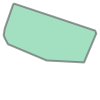

In [9]:
# Compute an approximate boundary of the Roman Empire by taking the convex hull
# of all the Roman roads. This will be used later to filter ports.
roman_boundary = roads_gdf.unary_union.convex_hull
roman_boundary

### 3. Load Ancient Ports Data ###

In [11]:
# Load the ancient ports CSV file
ports_df = pd.read_excel('AncientPorts_Europe.xlsx')
ports_df

,NAME,NAME_MOD,COUNTRY,LATITUDE,LONGITUDE
0,"Tyle, Thule","Iceland? Pliny and Strabo, who cite Pytheas (c...",Iceland,63.274770,-14.761314
1,"Export of amber to the Black Sea, on R Chesino...","Daugmale, on R Daugava, Dvina, Düna",Latvia,56.825000,24.410000
2,"Basileia, Basilia, Baltia, Ile Royale, between...","Sambia, Samland? near Kaliningrad, famous for ...",Russia,54.900000,20.000000
3,"Abalus insula, Saxonum insulae? near Elektride...",Isles of Helgoland? near Frisian islands in fr...,Germany,54.182500,7.885280
4,R Visurgis,"Roman statio at Bremen-Seehausen, on R Weser",Germany,53.122000,8.682000
...,...,...,...,...,...
3495,"Pinturia, Centuria, Ninguaria, Nivaria insula",Isla Tenerife,Spain,28.300000,-16.600000
3496,"Casperia, Capraria insula",Isla La Gomera,Spain,28.140000,-17.230000
3497,Ombrios insula,"Isla La Palma, La Bonita",Spain,28.646000,-17.842900
3498,"Junonia, Juno insula",Isla El Hierro,Spain,29.251000,-13.507000


In [13]:
# Create a GeoDataFrame for ports with EPSG:4326 CRS
ports_gdf = gpd.GeoDataFrame(
    ports_df,
    geometry=gpd.points_from_xy(
        ports_df['LONGITUDE'],
        ports_df['LATITUDE']
    ),
    crs='EPSG:4326'
)
ports_gdf

,NAME,NAME_MOD,COUNTRY,LATITUDE,LONGITUDE,geometry
0,"Tyle, Thule","Iceland? Pliny and Strabo, who cite Pytheas (c...",Iceland,63.274770,-14.761314,POINT (-14.76131 63.27477)
1,"Export of amber to the Black Sea, on R Chesino...","Daugmale, on R Daugava, Dvina, Düna",Latvia,56.825000,24.410000,POINT (24.41 56.825)
2,"Basileia, Basilia, Baltia, Ile Royale, between...","Sambia, Samland? near Kaliningrad, famous for ...",Russia,54.900000,20.000000,POINT (20 54.9)
3,"Abalus insula, Saxonum insulae? near Elektride...",Isles of Helgoland? near Frisian islands in fr...,Germany,54.182500,7.885280,POINT (7.88528 54.1825)
4,R Visurgis,"Roman statio at Bremen-Seehausen, on R Weser",Germany,53.122000,8.682000,POINT (8.682 53.122)
...,...,...,...,...,...,...
3495,"Pinturia, Centuria, Ninguaria, Nivaria insula",Isla Tenerife,Spain,28.300000,-16.600000,POINT (-16.6 28.3)
3496,"Casperia, Capraria insula",Isla La Gomera,Spain,28.140000,-17.230000,POINT (-17.23 28.14)
3497,Ombrios insula,"Isla La Palma, La Bonita",Spain,28.646000,-17.842900,POINT (-17.8429 28.646)
3498,"Junonia, Juno insula",Isla El Hierro,Spain,29.251000,-13.507000,POINT (-13.507 29.251)


In [15]:
# Filter ports to only those that fall within the approximate Roman Empire boundary.
ports_gdf = ports_gdf[ports_gdf.within(roman_boundary)]
ports_gdf

,NAME,NAME_MOD,COUNTRY,LATITUDE,LONGITUDE,geometry
6,Giricaemium?,"Winsum, terp Bruggeburen, on R Frjentsjerter F...",Netherlands,53.152800,5.632600,POINT (5.6326 53.1528)
7,"Mararmano, Manarmani, Meermanno, near archaic ...","in The Netherlands between R Vidrus (R Oer-IJ,...",Netherlands,53.041485,4.825152,POINT (4.82515 53.04148)
8,"Flevum, on R Vidrus?","Velsen 1, west of Amsterdam, on R Oer-IJ, now ...",Netherlands,52.458150,4.659740,POINT (4.65974 52.45815)
9,"Lugdunum Batavorum, Lugduno, Brittenburg, Call...",Roman fort still visible in the 17th c. at LLW...,Netherlands,52.219000,4.378000,POINT (4.378 52.219)
10,"Praetorium Agrippinae, on R Rhenus","Valkenburg, Marktveld-Weerdkampen, with recent...",Netherlands,52.174000,4.433000,POINT (4.433 52.174)
...,...,...,...,...,...,...
3474,"Port of Zilil, Zilis, Silis","Asilah, possible fish processing factory. Zili...",Morocco,35.467000,-6.040000,POINT (-6.04 35.467)
3475,"Lixus, Lynx, Trinx, on R Lixus","Tchemmich hill, 5 km east of Larache, very lar...",Morocco,35.196750,-6.109300,POINT (-6.1093 35.19675)
3476,"Banasa on R Sububus, Subur","Sidi Ali bou Jenoun on wadi Sebou, fish proces...",Morocco,34.602070,-6.115260,POINT (-6.11526 34.60207)
3477,"Thamusida on R Sububus, Subur","Sidi Ali ben Ahmed, Roman fort with Roman amph...",Morocco,34.335518,-6.489652,POINT (-6.48965 34.33552)


In [17]:
# Define colors and styles for road classification
color_dict = {
    'Major Road': 'dodgerblue',
    'Minor Road': 'silver'
}

### 4. Define Major Roman Cities ###

In [19]:
roman_cities = pd.DataFrame({
    "City": [
        "Rome", "Carthage", "Londinium", "Constantinople", "Alexandria", "Antioch",
        "Eburacum", "Ravenna", "Mediolanum", "Massilia", "Colonia Agrippina", "Aquincum",
        "Sirmium", "Emerita Augusta", "Tarraco", "Vindobona", "Jerusalem", "Caesarea",
        "Tauromenium", "Berytus", "Narbo Martius", "Patavium", "Neapolis",
        "Lutetia", "Lugdunum", "Cartagena", "Nîmes", "Arles", "Timgad", "Leptis Magna",
        "Thessalonica", "Ephesus", "Pergamum", "Brindisium", "Augusta Treverorum",
        "Viminacium", "Dura-Europos", "Verulamium", "Cyrene", "Syracuse"
    ],
    "Province": [
        "Italia", "Africa", "Britannia", "Asia", "Aegyptus", "Syria",
        "Britannia", "Italia", "Italia", "Gallia", "Germania Inferior", "Pannonia",
        "Pannonia", "Lusitania", "Hispania Tarraconensis", "Pannonia", "Palestina", "Judaea",
        "Sicilia", "Phoenice", "Gallia Narbonensis", "Italia", "Italia",
        "Gallia Lugdunensis", "Gallia Lugdunensis", "Hispania Carthaginensis", "Gallia Narbonensis",
        "Gallia Narbonensis", "Numidia", "Africa Proconsularis", "Macedonia", "Asia", "Asia",
        "Italia", "Gallia Belgica", "Moesia", "Syria", "Britannia", "Cyrenaica", "Sicilia"
    ],
    "Lat": [
        41.9028, 36.8528, 51.5074, 41.0082, 31.2001, 36.2021,
        53.9590, 44.4142, 45.4642, 43.2965, 50.9375, 47.4980,
        45.0038, 38.9160, 41.1189, 48.2082, 31.7683, 32.5000,
        37.8530, 33.8938, 43.1840, 45.4064, 40.8518,
        48.8566, 45.7640, 37.6050, 43.8367, 43.6766, 35.4875, 32.6396,
        40.6401, 37.9390, 39.1233, 40.6333, 49.75, 44.0167, 34.7878,
        51.75, 32.124, 37.0755
    ],
    "Lon": [
        12.4964, 10.3231, -0.1278, 28.9784, 29.9187, 37.1343,
        -1.0815, 12.1960, 9.1900, 5.3698, 6.9603, 19.0402,
        19.6120, -6.3430, 1.2445, 16.3738, 35.2137, 34.8920,
        15.2860, 35.5018, 3.0060, 11.8768, 14.2681,
        2.3522, 4.8357, -0.9869, 4.3601, 4.6280, 6.4689, 14.2904,
        22.9444, 27.3417, 27.1833, 17.9333, 6.6333, 21.3000, 40.9964,
        -0.3333, 21.769, 15.2866
    ],
    "Founding": [
        "753 BC", "814 BC", "AD 47", "AD 330", "331 BC", "c. 300 BC",
        "AD 71", "c. 500 BC", "c. 600 BC", "c. 600 BC", "AD 50", "AD 89",
        "c. 300 BC", "25 BC", "218 BC", "AD 15", "c. 3000 BC", "22 BC",
        "c. 396 BC", "15 BC", "118 BC", "c. 400 BC", "c. 600 BC",
        "c. 250 BC", "43 BC", "227 BC", "470 BC", "46 BC", "AD 100", "c. 1000 BC",
        "315 BC", "c. 10th century BC", "c. 300 BC", "254 BC", "16 BC",
        "AD 29", "303 BC", "AD 50", "631 BC", "8th century BC"
    ],
    "Population": [
        "2.8 million", "Tunis: ~638,000", "9 million", "15 million", "5 million", "150,000",
        "210,000", "160,000", "1.3 million", "861,000", "1.1 million", "1.75 million",
        "35,000", "60,000", "130,000", "1.9 million", "900,000", "3,000",
        "11,000", "2.2 million", "53,000", "210,000", "3 million",
        "2.1 million", "515,000", "215,000", "150,000", "53,000", "N/A", "150,000",
        "1 million", "N/A", "70,000", "88,000", "115,000", "N/A", "N/A",
        "147,000", "40,000", "120,000"
    ],
    "Modern": [
        "Rome", "Tunis", "London", "Istanbul", "Alexandria", "Antakya",
        "York", "Ravenna", "Milan", "Marseille", "Cologne", "Budapest",
        "Sremska Mitrovica", "Mérida", "Tarragona", "Vienna", "Jerusalem", "Caesarea",
        "Taormina", "Beirut", "Narbonne", "Padua", "Naples",
        "Paris", "Lyon", "Cartagena", "Nîmes", "Arles", "Timgad", "Al Khums",
        "Thessaloniki", "Selçuk", "Bergama", "Brindisi", "Trier",
        "Archaeological site near Kostolac", "Archaeological site near Deir ez-Zor", "St Albans", "Shahhat", "Syracuse"
    ]
})
roman_cities.head()

,City,Province,Lat,Lon,Founding,Population,Modern
0,Rome,Italia,41.9028,12.4964,753 BC,2.8 million,Rome
1,Carthage,Africa,36.8528,10.3231,814 BC,"Tunis: ~638,000",Tunis
2,Londinium,Britannia,51.5074,-0.1278,AD 47,9 million,London
3,Constantinople,Asia,41.0082,28.9784,AD 330,15 million,Istanbul
4,Alexandria,Aegyptus,31.2001,29.9187,331 BC,5 million,Alexandria


In [21]:
# Create a new column for hover text combining city and province and other info.
roman_cities['Hover'] = (
    roman_cities['City'] + ' (' + roman_cities['Province'] + '), ' +
    'Founding: ' + roman_cities['Founding'] + ', ' +
    'Population: ' + roman_cities['Population'] + ', ' +
    'Modern: ' + roman_cities['Modern']
)
roman_cities

,City,Province,Lat,Lon,Founding,Population,Modern,Hover
0,Rome,Italia,41.9028,12.4964,753 BC,2.8 million,Rome,"Rome (Italia), Founding: 753 BC, Population: 2..."
1,Carthage,Africa,36.8528,10.3231,814 BC,"Tunis: ~638,000",Tunis,"Carthage (Africa), Founding: 814 BC, Populatio..."
2,Londinium,Britannia,51.5074,-0.1278,AD 47,9 million,London,"Londinium (Britannia), Founding: AD 47, Popula..."
3,Constantinople,Asia,41.0082,28.9784,AD 330,15 million,Istanbul,"Constantinople (Asia), Founding: AD 330, Popul..."
4,Alexandria,Aegyptus,31.2001,29.9187,331 BC,5 million,Alexandria,"Alexandria (Aegyptus), Founding: 331 BC, Popul..."
5,Antioch,Syria,36.2021,37.1343,c. 300 BC,"150,000",Antakya,"Antioch (Syria), Founding: c. 300 BC, Populati..."
6,Eburacum,Britannia,53.9590,-1.0815,AD 71,"210,000",York,"Eburacum (Britannia), Founding: AD 71, Populat..."
7,Ravenna,Italia,44.4142,12.1960,c. 500 BC,"160,000",Ravenna,"Ravenna (Italia), Founding: c. 500 BC, Populat..."
8,Mediolanum,Italia,45.4642,9.1900,c. 600 BC,1.3 million,Milan,"Mediolanum (Italia), Founding: c. 600 BC, Popu..."
9,Massilia,Gallia,43.2965,5.3698,c. 600 BC,"861,000",Marseille,"Massilia (Gallia), Founding: c. 600 BC, Popula..."


### 5. Initialize Dash App and Layout ###

In [23]:
app = dash.Dash(__name__)

In [25]:
# Create dropdown options for road classes based on unique values in the original roads dataset.
road_class_options =[
    {'label': rc, 'value': rc} for rc in roads_gdf['CLASS'].unique()
]

In [27]:
# Set up the layout with controls and a graph.
app.layout = html.Div([
    html.H2('Roman Roads Dashboard'),
    html.Div([
        html.Label('Select Road Classes:'),
        dcc.Dropdown(
            id='road-class-dropdown',
            options=road_class_options,
            value=roads_gdf['CLASS'].unique().tolist(),  # default to all classes
            multi=True
        )
    ], style={'width': '30%', 'display': 'inline-block', 'verticalAlign': 'top'}),
    dcc.Graph(id='map-graph')
])

### 6. Callback: Update Map Based on User Selections ###

In [29]:
@app.callback(
    Output('map-graph', 'figure'),
    Input('road-class-dropdown', 'value')
)
def update_map(selected_classes):
    # Filter roads based on the selected classes.
    filtered = roads_gdf[roads_gdf['CLASS'].isin(selected_classes)].copy()
    
    # Apply fixed geometry simplification (tolerance set to 1000 meters).
    filtered['simp_geom'] = filtered.geometry.to_crs('EPSG:3857').simplify(
        tolerance=1000, preserve_topology=True
    ).to_crs('EPSG:4326')
    
    # Compute centroids and midpoints.
    filtered['centroid'] = filtered.geometry.centroid
    filtered['midpoint'] = filtered['simp_geom'].apply(lambda geom: geom.interpolate(0.5, normalized=True))
    
    # Create hover text for each road (with road length rounded to an integer).
    filtered['hover_text'] = (
        'Road Type: ' + filtered['CLASS'].astype(str) + ', ' +
        'Length: ' + filtered['Shape_Leng'].round(0).astype(int).astype(str) + ', ' +
        'Source: ' + filtered['SOURCE'].astype(str)
    )
    
    # Reassign styling parameters based on road type.
    filtered['color'] = filtered['CLASS'].map(color_dict)
    filtered['opacity'] = filtered['CLASS'].apply(lambda x: 1.0 if x == 'Major Road' else 0.7)
    filtered['width'] = filtered['CLASS'].apply(lambda x: 0.9 if x == 'Major Road' else 0.7)
    
    # Aggregate Roads by Class
    traces = []
    for road_class, group in filtered.groupby('CLASS'):
        all_lats = []
        all_lons = []
        for idx, row in group.iterrows():
            coords = list(row['simp_geom'].coords)
            all_lats.extend([pt[1] for pt in coords] + [None])
            all_lons.extend([pt[0] for pt in coords] + [None])
        style_color = group.iloc[0]['color']
        style_width = group.iloc[0]['width']
        style_opacity = group.iloc[0]['opacity']
        traces.append(go.Scattermapbox(
            lat=all_lats,
            lon=all_lons,
            mode='lines',
            line=dict(
                color=style_color,
                width=style_width
            ),
            opacity=style_opacity,
            hoverinfo='none',
            name=road_class
        ))
    
    # Add invisible markers at road midpoints for detailed hover information.
    traces.append(go.Scattermapbox(
        lat=filtered['midpoint'].apply(lambda point: point.y),
        lon=filtered['midpoint'].apply(lambda point: point.x),
        mode='markers',
        marker=dict(
            size=4,
            color='rgba(0,0,0,0)'
        ),
        text=filtered['hover_text'],
        hovertemplate='%{text}<extra></extra>',
        name='Road Details'
    ))
    
    # Add Ancient Ports Layer
    ports_trace = go.Scattermapbox(
        lat=ports_gdf.geometry.y,
        lon=ports_gdf.geometry.x,
        mode='markers',
        marker=dict(
            size=5,
            color='yellow'
        ),
        text=ports_gdf['NAME'],
        hovertemplate='Port: %{text}<extra></extra>',
        name='Ancient Ports'
    )
    traces.append(ports_trace)
    
    # Add Roman Cities Layer
    cities_trace = go.Scattermapbox(
        lat=roman_cities['Lat'],
        lon=roman_cities['Lon'],
        mode='markers',
        marker=dict(
            size=8,
            color='red'
        ),
        text=roman_cities['Hover'],
        hovertemplate='%{text}<extra></extra>',
        hoverlabel=dict(bgcolor='red'),
        name='Roman Cities'
    )
    traces.append(cities_trace)
    
    # Create and Center the Map
    fig = go.Figure(data=traces)
    if len(filtered) > 0:
        center_lat = filtered['centroid'].y.mean()
        center_lon = filtered['centroid'].x.mean()
    else:
        center_lat, center_lon = ((lat_min + lat_max) / 2, (lon_min + lon_max) / 2)
    
    fig.update_layout(
        mapbox_style='carto-darkmatter',
        mapbox_zoom=4,
        mapbox_center={
            'lat': center_lat,
            'lon': center_lon},
        height=600,
        margin=dict(
            l=0,
            r=0,
            t=0,
            b=0
        )
    )
    return fig

### 7. Run the Dash App ###

In [31]:
if __name__ == '__main__':
    app.run_server(debug=True)